# nbed library: Binning and Export
L. Houben, Weizmann Institute of Science
last updated January 2026

- Load a 4D STEM nanobeam diffraction data set.
  This script uses a data set that can be downloaded from https://doi.org/10.5281/zenodo.15212905
- Bin the data to obtain smaller file sizes
- Export the data as raw binary file, MRC 3D sequence of frames or as Numpy file

In [1]:
import numpy as np
import numpy.matlib
#from objbrowser import browse
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pims
import trackpy as tp
# for animated view
import time
from IPython import display
%matplotlib inline
import os
# load nbed module and helper routines
# possibly installed under miniforge3/envs/py4Dstem/lib/python3.9/site-packages
import nbed
from nbed import ParabolaFit2D,bytscl

## Define filename, create class instance, load the data set, and display a single frame 
Currently supported formats: 
- PantaRhei .prz (default)
- EMPAD .raw
- sbin and qbin are the binning factors for the real and momentum space

In [2]:
# Path definition and filename
# export format
path="/Users/houben/Downloads/"
filebasename="Coccolithophore0025"
filesuffix="prz"
sbin=2 # spatial binning
qbin=2 # momentum space binning
exportas="mrc" # possible options: "raw", "mrc", "npy" 

In [3]:
# create an instance of the pyNBED module and load data
myset=nbed.pyNBED()
myset.LoadFile(path+filebasename+'.'+filesuffix)

pyNBED: Loading object descriptor: /Users/houben/Downloads/Coccolithophore0025.prz
pyNBED: Loading data ...
        finished
pyNBED: array dimensions: (217, 256, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


### Bin the 4D dataset

In [4]:
# spatial binning
if sbin > 1:
    myset.SpatialBinning(bin=sbin)

pyNBED: Original array dimensions - (217, 256, 256, 256)
pyNBED: Binned array dimensions: (108, 128, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


In [5]:
# frame binning
if qbin > 1:
    myset.FrameBinning(bin=qbin)

pyNBED: Original array dimensions - (108, 128, 256, 256)
pyNBED: Binned array dimensions -  (108, 128, 128, 128)
pyNBED: Preparing reciprocal space sampling grid


### Create a virtual aperture image and display a single diffraction frame

In [6]:
mask,adf=myset.VirtualApertureImage(radius=[0,10],invert=True)

/Users/houben/miniforge3/envs/py4dstem/lib/python3.12/site-packages/nbed/helpers.py:105: RuntimeWarning: invalid value encountered in cast
  img8bit[img < vmin]=vmin


<Figure size 640x480 with 0 Axes>

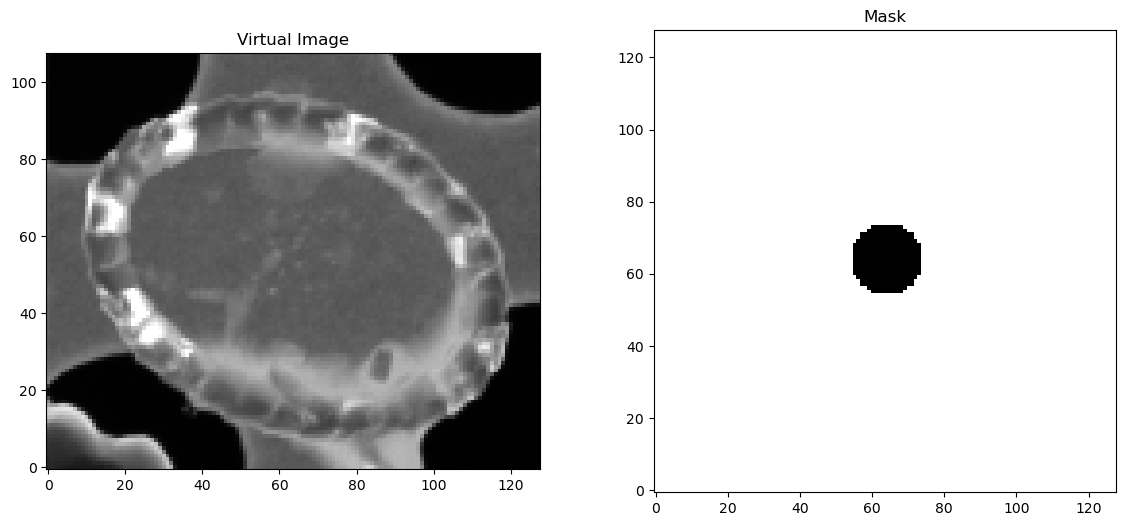

In [7]:
# plot the image
#dispimage=np.log(vimage)
dispimage=adf
plt.figure()
#subplot(r,c) provide the no. of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax1.imshow(bytscl(dispimage,vmin=np.mean(dispimage)-3*np.std(dispimage),vmax=np.mean(dispimage)+3*np.std(dispimage)),cmap='gray',origin="lower") 
ax1.set_title('Virtual Image')
ax2.imshow(mask,cmap='gray',origin="lower")
ax2.set_title('Mask')
plt.show()

frame coordinates: 87 47
frame dimensions:  (128, 128)


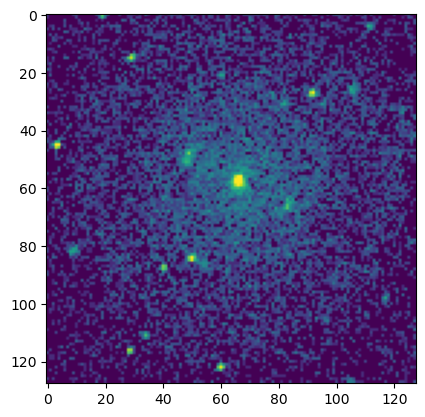

In [8]:
# Display a single frame at row 174, column 94
frame=myset.ShowFrame(i=174//sbin, j=94//sbin,Log=True, sd=6)

### Export as MRC

In [ ]:
myset.StackExport(format="mrc")

In [ ]:
def StackExport(self, outpath=None, format='raw'):
    
    if outpath is None:
        dirname = os.path.dirname(self.fname)
    else: 
        dirname=outpath
    print(dirname)
    basename_without_ext = os.path.splitext(os.path.basename(self.fname))[0]
    basename=dirname+os.sep+basename_without_ext
    fnout=basename+'-'+str(self.dim[1])+'x'+str(self.dim[0])+'_'+str(self.dim[2])+'x'+str(self.dim[3])+'_'+str(self.dim[1]*self.dim[0])+'frames'
    if (format == "raw"):
        # save as 3D binary data
        # split self.fname into path and suffix            
        fnout=fnout+'_float32.raw'
        (self.data.reshape(self.dim[0]*self.dim[1],self.dim[2],self.dim[3])).astype('float32').tofile(fnout)
        print("pyNBED: Wrote ",fnout)
    if (format == "mrc"):
        # save as MRC 3D data
        # split self.fname into path and suffix            
        fnout=fnout+"_float32.mrc"
        with mrcfile.new(fnout, overwrite=True) as mrc:
            mrc.set_data((self.data.reshape(self.dim[0]*self.dim[1],self.dim[2],self.dim[3])).astype('float32'))
            # header data: starts with 10 int32 values: nx, ny,nz; dtype; location of first uc x,y,z; Number of samples along the uc x,y,z; 
            #              continues with the cell size in A as float32;
            (mrc.header)["cella"]=(self.dim[1]*10,self.dim[2]*10,self.dim[0]*10)
            #print("MRC header ",mrc.header)
            mrc.set_image_stack()
            mrc.close()
        print("pyNBED: Wrote ",fnout)
    if (format == "npy"):
        fnout=fnout+"_float32.npy"
        np.save(fnout, (self.data).astype('float32'))
        print("pyNBED: Wrote ",fnout)


In [ ]:
StackExport(myset,format="npy")